In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [66]:
def generate_samples(num_samples=10000):
    mu1 = torch.tensor([0, 0], dtype=torch.float32)
    mu2 = torch.tensor([2, 2], dtype=torch.float32)
    mu3 = torch.tensor([-2, 2], dtype=torch.float32)

    sigma = 2 * torch.eye(2)

    n1 = num_samples // 3
    n2 = num_samples // 3
    n3 = num_samples - n1 - n2

    z1 = torch.distributions.MultivariateNormal(mu1, sigma).sample((n1,))
    z2 = torch.distributions.MultivariateNormal(mu2, sigma).sample((n2,))
    z3 = torch.distributions.MultivariateNormal(mu3, sigma).sample((n3,))

    z = torch.cat((z1, z2, z3), dim=0)
    z = z[torch.randperm(num_samples)]

    return z

In [67]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

In [68]:
batch_size = 1000
num_epochs = 5000
lr = 0.0002
input_dim = 2
latent_dim = 2
output_dim = 1

generator = Generator(input_dim, latent_dim)
discriminator = Discriminator(input_dim, output_dim)

# loss function
criterion = nn.BCELoss()

# optimizer
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# generate samples
z = generate_samples(10000)

In [69]:
def train_gan(generator, discriminator, z, num_epochs=5000, batch_size=128):
    lossg = []
    lossd = []
    for epoch in range(num_epochs):
        # training discriminator on real data
        discriminator.zero_grad()
        real_data = z
        real_labels = torch.ones(real_data.shape[0], 1)
        output = discriminator(real_data)
        loss1 = criterion(output, real_labels)
        loss1.backward()
        optimizer_d.step()
        # training discriminator on fake data
        discriminator.zero_grad()
        fake_data = generator(torch.randn(batch_size, latent_dim))
        fake_labels = torch.zeros(batch_size, 1)
        output = discriminator(fake_data)
        loss2 = criterion(output, fake_labels)
        loss2.backward()
        lossd.append((loss1.item() + loss2.item()) / 2)
        optimizer_d.step()
        # training generator
        generator.zero_grad()
        fake_data = generator(torch.randn(batch_size, latent_dim))
        fake_labels = torch.ones(batch_size, 1)
        output = discriminator(fake_data)
        loss = criterion(output, fake_labels)
        loss.backward()
        lossg.append(loss.item())
        optimizer_g.step()
        # printing loss
        print('Epoch: {}, Loss G: {}, Loss D: {}'.format(epoch, loss.item(), (loss1.item() + loss2.item()) / 2))

        # loss vs epoch curve
    plt.plot(lossg, label='Loss G')
    plt.plot(lossd, label='Loss D')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return generator, discriminator

Epoch: 0, Loss G: 0.7019774317741394, Loss D: 0.730231910943985
Epoch: 1, Loss G: 0.6987269520759583, Loss D: 0.716407060623169
Epoch: 2, Loss G: 0.6963434219360352, Loss D: 0.7063445150852203
Epoch: 3, Loss G: 0.6943627595901489, Loss D: 0.6970862448215485
Epoch: 4, Loss G: 0.6926689743995667, Loss D: 0.6882842779159546
Epoch: 5, Loss G: 0.6911093592643738, Loss D: 0.6799245178699493
Epoch: 6, Loss G: 0.6895660161972046, Loss D: 0.6720820665359497
Epoch: 7, Loss G: 0.6881919503211975, Loss D: 0.6643006503582001
Epoch: 8, Loss G: 0.6868956089019775, Loss D: 0.6569656431674957
Epoch: 9, Loss G: 0.6863245368003845, Loss D: 0.6497420370578766
Epoch: 10, Loss G: 0.6854230165481567, Loss D: 0.6428657472133636
Epoch: 11, Loss G: 0.6844503283500671, Loss D: 0.6364262998104095
Epoch: 12, Loss G: 0.6845892667770386, Loss D: 0.6299548149108887
Epoch: 13, Loss G: 0.6841297745704651, Loss D: 0.6235379278659821
Epoch: 14, Loss G: 0.6818381547927856, Loss D: 0.6176062524318695
Epoch: 15, Loss G: 0.6

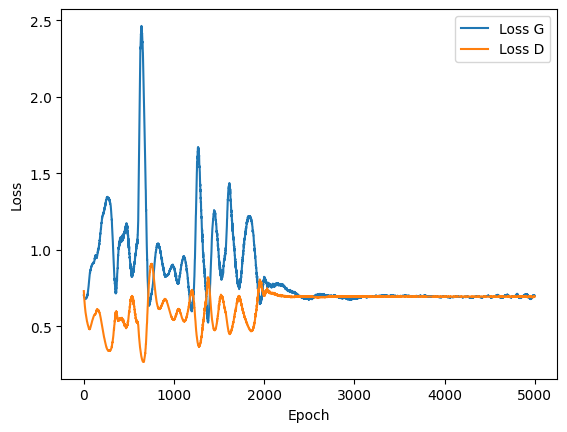

In [70]:
# training gan
generator, discriminator = train_gan(generator, discriminator, z, num_epochs, batch_size)

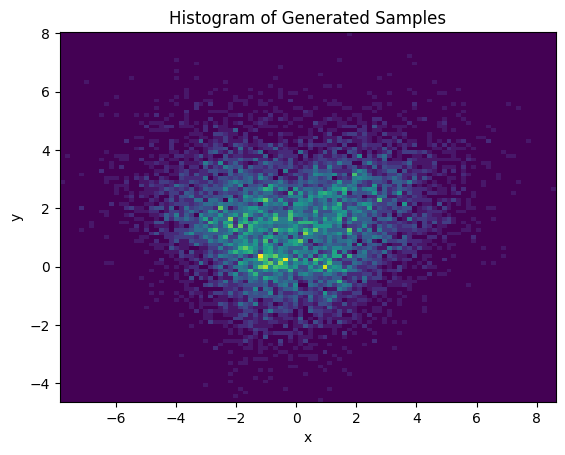

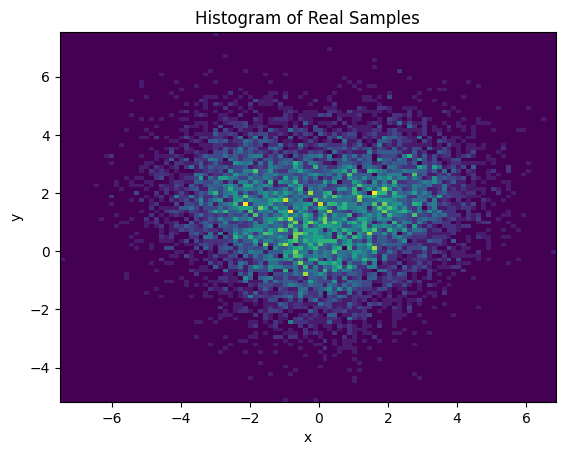

In [72]:
def generate(generator, num_samples=10000):
    x = generator(torch.randn(num_samples, input_dim)).detach().numpy()
    return x

x = generate(generator)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Histogram of Generated Samples')
plt.show()

plt.hist2d(z[:, 0], z[:, 1], bins=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Histogram of Real Samples')
plt.show()